### Model A - Convolutional LSTM for coordinate prediction - PyTorch

### Imports

In [1]:
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchinfo import summary

from tqdm.auto import tqdm

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### Load datasets

In [18]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

In [3]:
# input size is 960 or 1
train_imgs = True
save_infos = False

# preprocessing
seq_length = 20
training_set_size = 0.80

# lstm configuration
hidden_size = 200
num_layers = 1
num_classes = 2
save_model = False
input_size = 960

# training
num_epochs = 200
learning_rate = 0.01
optimizer_type = "Adam"

In [2]:
import numpy as np

def sliding_windows(dataset, seq_length, hot_encoding=True):
    x_coords = []
    y_coords = []

    positions = dataset["positions"]
    imgs = dataset["observations"]

    # preprocess coords
    coords = [[i[0], i[2]] for i in positions]

    # preprocess images
    x_imgs = []
    for img in imgs:
        img = torch.from_numpy(img).float()
        img = img.permute(2, 0, 1)
        x_imgs.append(img)
    x_imgs_processed = torch.stack(x_imgs)

    # actual sliding window
    x_imgs = []
    for i in range(len(coords) - seq_length - 1):
        _x_coords = coords[i : (i + seq_length)]
        _x_imgs = x_imgs_processed[i : (i + seq_length)]
        _y_coords = coords[i + 1 + seq_length]  # _y = data[i+seq_length]

        x_coords.append(_x_coords)
        x_imgs.append(_x_imgs)
        y_coords.append(_y_coords)

    x_imgs = torch.stack(x_imgs)

    return np.array(x_coords), x_imgs, np.array(y_coords)  # train, val. data

In [4]:
import random

def split(x_acts, x_imgs, y_acts, training_set_size):

    train_size = int(len(x_acts) * training_set_size)
    test_size = len(x_acts) - train_size
    
    idx_shuf = list(range(len(x_acts)))
    random.shuffle(idx_shuf)

    x_acts = [x_acts[i] for i in idx_shuf]
    y_acts = [y_acts[i] for i in idx_shuf]
    
    x_imgs_shuffled = []
    for i in idx_shuf:
        x_imgs_shuffled.append(x_imgs[i])
        
    x_imgs = torch.stack(x_imgs_shuffled)
    
    x_acts = np.asarray(x_acts)
    y_acts = np.asarray(y_acts)
    
    print('types', type(x_acts), type(x_imgs), type(y_acts))
    
    # (full) data set
    dataX_acts = Variable(torch.Tensor(np.array(x_acts)))
    dataX_imgs = Variable(torch.Tensor(x_imgs))
    dataY_acts = Variable(torch.Tensor(np.array(y_acts)))

    # training set
    trainX_acts = Variable(torch.Tensor(np.array(x_acts[0:train_size])))
    trainX_imgs = Variable(torch.Tensor(np.array(x_imgs[0:train_size])))
    trainY_acts = Variable(torch.Tensor(np.array(y_acts[0:train_size])))

    # validation set
    testX_acts = Variable(torch.Tensor(np.array(x_acts[train_size : len(x_acts)])))
    testX_imgs = Variable(torch.Tensor(np.array(x_imgs[train_size : len(x_imgs)])))
    testY_acts = Variable(torch.Tensor(np.array(y_acts[train_size : len(y_acts)])))

    return (
        [dataX_acts, dataX_imgs, dataY_acts],
        [trainX_acts, trainX_imgs, trainY_acts],
        [testX_acts, testX_imgs, testY_acts],
    )

### Preprocess data

In [20]:
hot_encoding = True

# preprocess with sequence length
x_coords, x_imgs, y_coords = sliding_windows(
    oracle_data, seq_length, hot_encoding
)

# data, train, test split
data, train, test = split(x_coords, x_imgs, y_coords, training_set_size)
dataX_acts, dataX_imgs, dataY_acts = data
trainX_acts, trainX_imgs, trainY_acts = train
testX_acts, testX_imgs, testY_acts = test

types <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>


### Initialize models

In [21]:
# initialize network
cnn = nets.CNN(seq_length)
lstm = nets.LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

features = cnn(trainX_imgs[0:32])
outputs = lstm(features)

print("CNN input shape:", trainX_imgs[0:32].size())
print("CNN output shape:", features.size())

print("LSTM input shape:", features.size())
print("LSTM output shape:", outputs.size())

print("Label shape:", trainY_acts[0:32].size())

print("SUMMARY CNN \n", summary(cnn, trainX_imgs[0:32].size()), "\n")
print('SUMMARY LSTM \n', summary(lstm, (32, 20, 960)))


CNN input shape: torch.Size([32, 20, 3, 32, 32])
CNN output shape: torch.Size([32, 20, 960])
LSTM input shape: torch.Size([32, 20, 960])
LSTM output shape: torch.Size([32, 2])
Label shape: torch.Size([32, 2])
SUMMARY CNN 
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 20, 960]             --
├─Conv2d: 1-1                            [640, 20, 28, 28]         1,520
├─Conv2d: 1-2                            [640, 40, 24, 24]         20,040
├─MaxPool2d: 1-3                         [640, 40, 12, 12]         --
├─Conv2d: 1-4                            [640, 60, 8, 8]           60,060
├─MaxPool2d: 1-5                         [640, 60, 4, 4]           --
Total params: 81,620
Trainable params: 81,620
Non-trainable params: 0
Total mult-adds (G): 10.61
Input size (MB): 7.86
Forward/backward pass size (MB): 217.91
Params size (MB): 0.33
Estimated Total Size (MB): 226.10

SUMMARY LSTM 
Layer (type:depth-idx)                   

In [6]:
from matplotlib import pyplot as plt

def plot_losses(train_loss, test_loss, num_epochs):

    font = 24
    hfont = {"fontname": "Helvetica"}

    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams["axes.titlepad"] = 13
    plt.rcParams["xtick.major.pad"] = "8"  # axis distance
    plt.rcParams["ytick.major.pad"] = "8"

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    with plt.style.context("seaborn-darkgrid"):

        plt.rcParams.update({"font.size": font})
        plt.plot(test_loss, color="red", linewidth=2, label="Validation Loss")
        plt.plot(train_loss, color="slategray", linewidth=2, label="Training Loss")
        plt.legend(fontsize=font)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss")

        # plt.savefig('difficult_env_loss_epochs.pdf', bbox_inches="tight")
        plt.show()


def plot_acc(train_dis, test_dis, num_epochs):

    font = 24
    hfont = {"fontname": "Helvetica"}

    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams["axes.titlepad"] = 13
    plt.rcParams["xtick.major.pad"] = "8"  # axis distance
    plt.rcParams["ytick.major.pad"] = "8"

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.rcParams.update({"font.size": font})

    with plt.style.context("seaborn-darkgrid"):
        plt.plot(train_dis, label="Training", linewidth=3, color="tab:blue")
        plt.plot(test_dis, c="indianred", label="Validation", linewidth=3)
        plt.legend(fontsize=font)
        plt.xlabel("Epochs", fontsize=font, **hfont)
        plt.ylabel("Distance", fontsize=font, **hfont)

        #plt.xlim(xmax=num_epochs + 5, xmin=-2)

        # plt.savefig('difficult_env_euclidean_distance_epochs.pdf', bbox_inches="tight")

        plt.show()

In [12]:
def training_loop(trainX_imgs, trainY_acts, testX_imgs, testY_acts, seq_length):
    
    num_epochs = 200

    with tqdm(total=num_epochs, unit=" Episode", desc="Progress") as pbar:

        seq_length = 20
        learning_rate = 0.0001 # 0.0001 ?
        hidden_size = 200

        cnn = nets.CNN(seq_length)
        lstm = nets.LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
        criterion = torch.nn.MSELoss()

        params = list(cnn.parameters()) + list(lstm.parameters())
        optimizer = torch.optim.Adam(params, lr=learning_rate)

        # tracking results
        train_loss_lst, test_loss_lst = [], []
        train_dis_lst, test_dis_lst = [], []

        for epoch in range(num_epochs):

            loss_test_col = 0
            loss_train_col = 0
            test_dis_col = 0
            train_dis_col = 0
            
            optimal_test = len(testY_acts)//32
            
            # test set
            for i in range(optimal_test):
                test_dist = 0
                start = 32*i
                end = 32*(i+1)
                # compute validation set performance
                with torch.no_grad():
                    # choose training style
                    if train_imgs:
                        features = cnn(testX_imgs[start:end])
                    else:
                        features = testX_acts
                    outputs = lstm(features)
            
                    # loss
                    loss_test = criterion(outputs, testY_acts[start:end])
                    loss_test_col += loss_test.item()

                    # compute test distance
                    values = testY_acts[start:end]
                    for idx in range(32):
                        test_dist += ((outputs[:][idx][0] - values[idx][0]) ** 2 + (outputs[:][idx][1] - values[idx][1]) ** 2 ) ** 0.5
                    test_dist = test_dist / 32
                    test_dis_col += test_dist
                    
            optimal_train = len(trainY_acts)//32
            
            # training set
            for i in range(optimal_train):
                train_dist = 0
                start = 32*i
                end = 32*(i+1)
                # choose training style
                if train_imgs:
                    features = cnn(trainX_imgs[start:end])  # forwarad pass of the cnn
                else:
                    features = trainX_acts

                # forwarad pass of the lstm
                outputs = lstm(features)                
                optimizer.zero_grad()  # zero the parameter gradients

                # loss + optimize
                loss_train = criterion(outputs, trainY_acts[start:end])
                loss_train.backward()
                optimizer.step()

                loss_train_col += loss_train.item()

                # compute test distance
                values = trainY_acts[start:end]
                for idx in range(32):
                    train_dist += ((outputs[idx][0] - values[:][idx][0]) ** 2 + (outputs[idx][1] - values[:][idx][1]) ** 2 ) ** 0.5
                train_dist = train_dist / 32
                train_dis_col += train_dist

            #features = cnn(trainX_imgs[0:32])
            #outputs = lstm(features)
            #print('predicted', round(outputs[0][0].item(), 5), 'actual', round(trainY_acts[start:end][0][0].item(), 5))
            
            # display
            if epoch % (num_epochs / 10) == 0:
                epoch = (4 - len(str(epoch))) * str(0) + str(epoch)
                print(
                    "Epoch: %s - Train Loss: %1.3f, Train Dist: %1.3g - Test Loss: %1.3f, Test Dist: %1.3g"
                    % (epoch, loss_train_col/optimal_train, train_dis_col/optimal_train, loss_test_col/optimal_test, test_dis_col/optimal_test)
                )
            #print(features)

            # collect tensorboard logs

            # collect plotting logs
            train_loss_lst.append(loss_train_col/optimal_train)
            test_loss_lst.append(loss_test_col/optimal_test)
            train_dis_lst.append(train_dis_col.item()/optimal_train)
            test_dis_lst.append(test_dis_col.item()/optimal_test)

            pbar.update(1)

        plot_losses(train_loss_lst, test_loss_lst, num_epochs)
        plot_acc(train_dis_lst, test_dis_lst, num_epochs)
        
        print(outputs)
        print(features)
        
        print("Finished Training")
        
        return train_dis_lst, test_dis_lst
    


In [ ]:
train_dis_lst, test_dis_lst = training_loop(trainX_imgs, trainY_acts, testX_imgs, testY_acts, seq_length)


sequence lenth 20 easy environment
types <class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'numpy.ndarray'>


Progress:   0%|          | 0/200 [00:00<?, ? Episode/s]

Epoch: 0000 - Train Loss: 223.129, Train Dist: 20.3 - Test Loss: 246.937, Test Dist: 21.5
Epoch: 0020 - Train Loss: 46.786, Train Dist: 9.1 - Test Loss: 46.113, Test Dist: 9.05
Epoch: 0040 - Train Loss: 46.797, Train Dist: 9.1 - Test Loss: 46.132, Test Dist: 9.06
Epoch: 0060 - Train Loss: 46.794, Train Dist: 9.1 - Test Loss: 46.145, Test Dist: 9.05
Epoch: 0080 - Train Loss: 45.243, Train Dist: 8.95 - Test Loss: 44.607, Test Dist: 8.91
Epoch: 0100 - Train Loss: 38.950, Train Dist: 8.23 - Test Loss: 39.584, Test Dist: 8.28
Epoch: 0120 - Train Loss: 32.246, Train Dist: 7.37 - Test Loss: 34.508, Test Dist: 7.59
Epoch: 0140 - Train Loss: 21.690, Train Dist: 5.85 - Test Loss: 24.533, Test Dist: 6.21
Epoch: 0160 - Train Loss: 8.522, Train Dist: 3.42 - Test Loss: 10.892, Test Dist: 3.84
Epoch: 0180 - Train Loss: 3.425, Train Dist: 2.11 - Test Loss: 5.118, Test Dist: 2.55


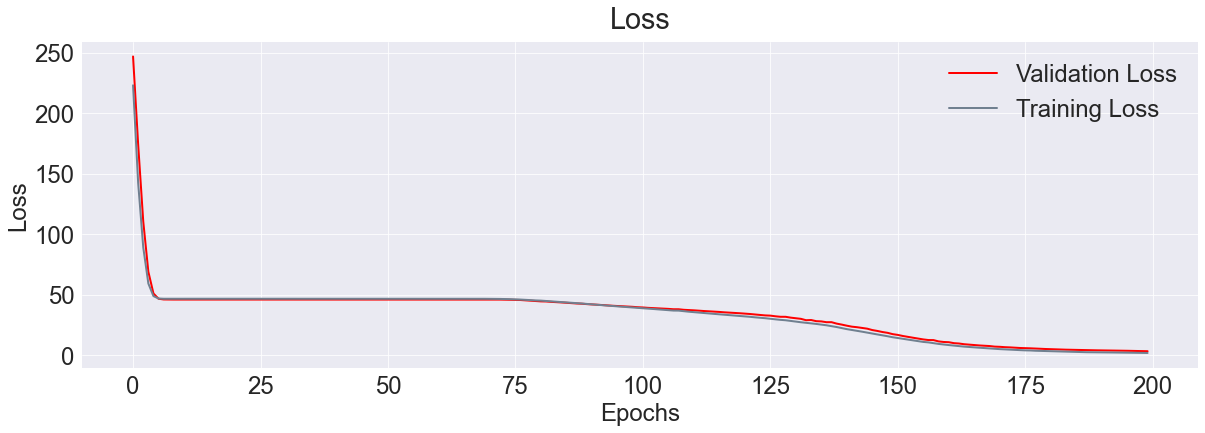

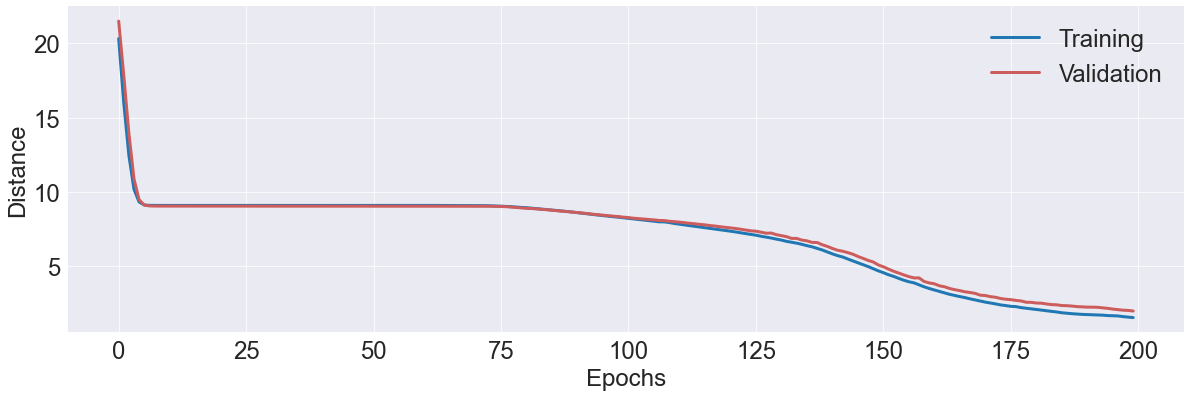

tensor([[ 2.8757, 12.1593],
        [14.0734,  0.9410],
        [ 2.1862, 15.1377],
        [12.2966,  4.0620],
        [14.5647, 10.8032],
        [12.3054, 14.8801],
        [14.9876, 18.9572],
        [16.7096, 10.3600],
        [22.5546,  8.1448],
        [16.8439, 12.3514],
        [15.8735, 11.7553],
        [10.9898, 23.3106],
        [14.0062,  4.4521],
        [25.0965, 15.3641],
        [18.8019,  2.6914],
        [ 7.9138, 13.5040],
        [10.6386,  9.3415],
        [ 2.1464, 17.6579],
        [ 9.8919, 10.8269],
        [ 6.7231, 25.0396],
        [13.7793, 22.3805],
        [ 7.4957,  8.2889],
        [13.6816,  5.5335],
        [17.0855,  9.3759],
        [12.9647, 21.6591],
        [20.0598, 15.4305],
        [13.9867,  1.1156],
        [ 6.9365, 24.4236],
        [14.2203, 12.8755],
        [14.8531, 23.7336],
        [12.1416,  6.0464],
        [17.7428,  5.7602]], grad_fn=<AddmmBackward0>)
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.8591],
      

Progress:   0%|          | 0/200 [00:00<?, ? Episode/s]

Epoch: 0000 - Train Loss: 130.800, Train Dist: 15.4 - Test Loss: 159.954, Test Dist: 17.3
Epoch: 0020 - Train Loss: 34.342, Train Dist: 7.54 - Test Loss: 35.706, Test Dist: 7.7
Epoch: 0040 - Train Loss: 34.116, Train Dist: 7.52 - Test Loss: 35.499, Test Dist: 7.68
Epoch: 0060 - Train Loss: 33.157, Train Dist: 7.4 - Test Loss: 34.758, Test Dist: 7.59
Epoch: 0080 - Train Loss: 31.661, Train Dist: 7.21 - Test Loss: 33.645, Test Dist: 7.43
Epoch: 0100 - Train Loss: 29.511, Train Dist: 6.91 - Test Loss: 31.797, Test Dist: 7.19
Epoch: 0120 - Train Loss: 26.374, Train Dist: 6.48 - Test Loss: 28.945, Test Dist: 6.79
Epoch: 0140 - Train Loss: 22.797, Train Dist: 5.98 - Test Loss: 25.415, Test Dist: 6.36
Epoch: 0160 - Train Loss: 20.400, Train Dist: 5.59 - Test Loss: 23.432, Test Dist: 6.05
Epoch: 0180 - Train Loss: 17.811, Train Dist: 5.16 - Test Loss: 19.228, Test Dist: 5.42


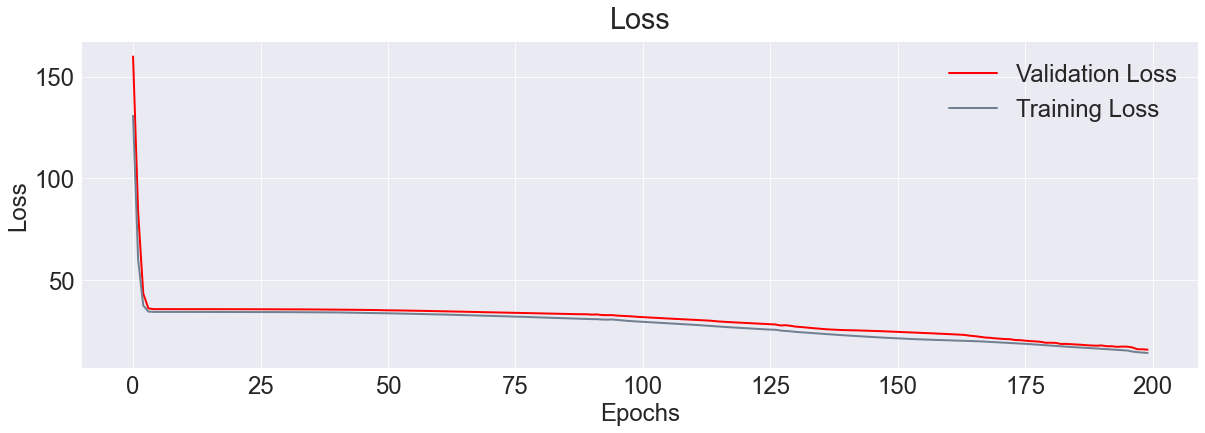

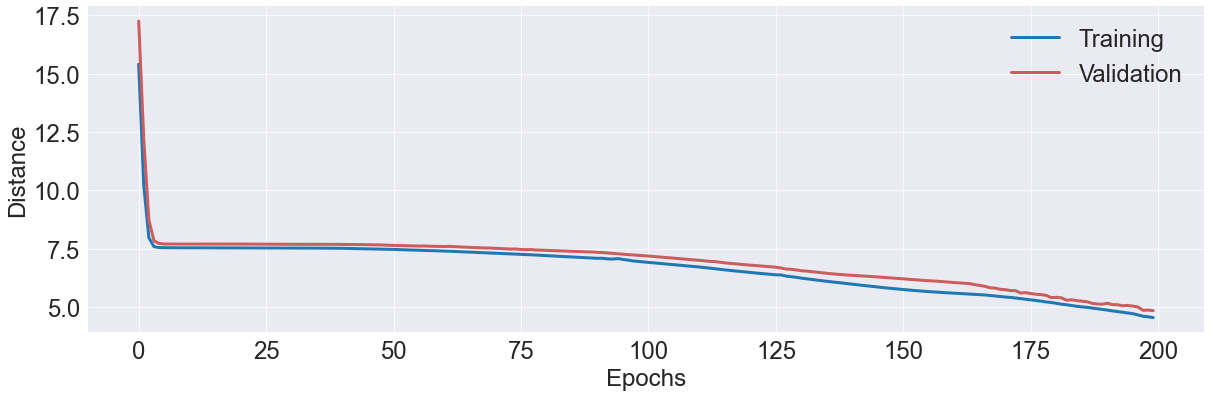

tensor([[ 7.8065, 18.1295],
        [ 4.4896, 24.5459],
        [ 6.8527,  9.0333],
        [10.3204,  6.8195],
        [ 7.7333, 19.0309],
        [ 7.5629, 16.2584],
        [ 7.1602, 20.0793],
        [ 7.4720, 18.8618],
        [ 9.2291, 13.1863],
        [ 8.8365, 14.2593],
        [ 6.0718, 13.8622],
        [ 9.9627, 11.5898],
        [ 9.8764, 11.7823],
        [ 6.3448, 20.9688],
        [ 8.2700, 15.1389],
        [ 6.8546,  9.0124],
        [ 9.4659,  6.8453],
        [ 8.0991, 10.5236],
        [ 7.5078, 19.3662],
        [ 6.5440, 20.8049],
        [ 7.7497, 15.7246],
        [ 7.5909, 19.2867],
        [ 8.0784, 15.4260],
        [ 9.8425,  7.9626],
        [10.2261,  6.4046],
        [ 7.6731, 15.9219],
        [ 8.2163, 15.2730],
        [ 6.8411, 20.3726],
        [ 9.0849,  8.5553],
        [ 9.2172, 12.0855],
        [ 6.5293, 18.1446],
        [ 6.2783, 20.8817]], grad_fn=<AddmmBackward0>)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

Progress:   0%|          | 0/200 [00:00<?, ? Episode/s]

Epoch: 0000 - Train Loss: 2.832, Train Dist: 2.11 - Test Loss: 3.951, Test Dist: 2.47
Epoch: 0020 - Train Loss: 1.562, Train Dist: 1.59 - Test Loss: 1.520, Test Dist: 1.53
Epoch: 0040 - Train Loss: 0.123, Train Dist: 0.421 - Test Loss: 0.146, Test Dist: 0.458
Epoch: 0060 - Train Loss: 0.056, Train Dist: 0.277 - Test Loss: 0.074, Test Dist: 0.318
Epoch: 0080 - Train Loss: 0.026, Train Dist: 0.19 - Test Loss: 0.043, Test Dist: 0.242
Epoch: 0100 - Train Loss: 0.017, Train Dist: 0.155 - Test Loss: 0.028, Test Dist: 0.195
Epoch: 0120 - Train Loss: 0.015, Train Dist: 0.144 - Test Loss: 0.035, Test Dist: 0.217
Epoch: 0140 - Train Loss: 0.009, Train Dist: 0.115 - Test Loss: 0.021, Test Dist: 0.17
Epoch: 0160 - Train Loss: 0.007, Train Dist: 0.1 - Test Loss: 0.015, Test Dist: 0.146
Epoch: 0180 - Train Loss: 0.006, Train Dist: 0.0954 - Test Loss: 0.015, Test Dist: 0.145


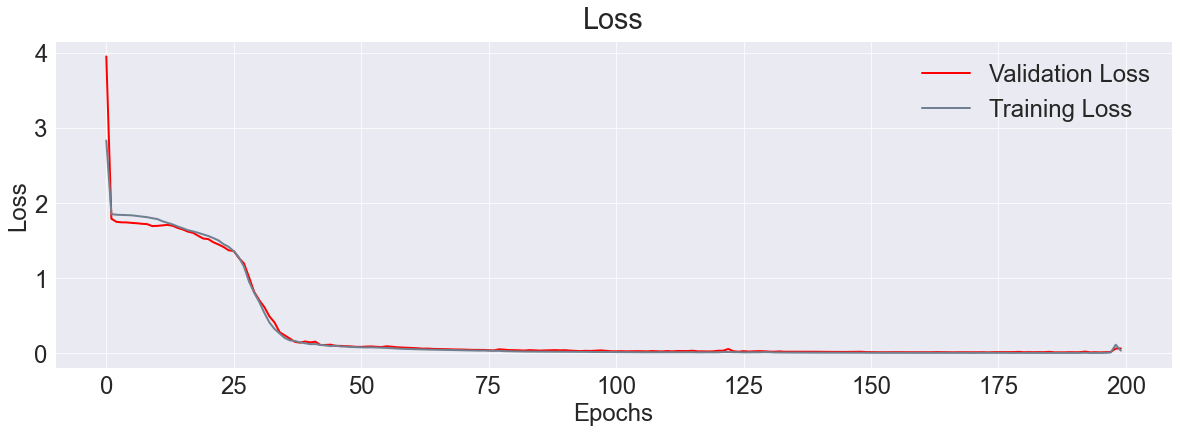

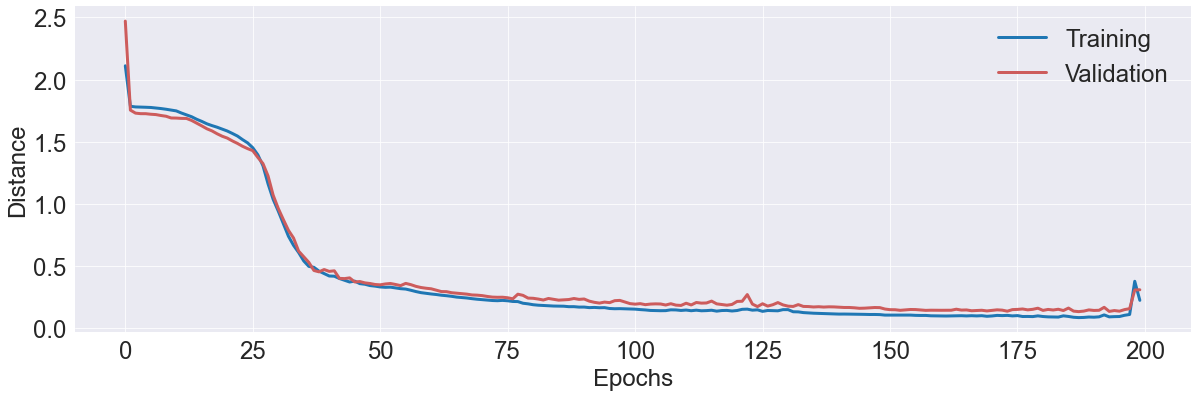

tensor([[-4.8050e-01,  9.4307e-01],
        [ 7.1557e-01,  1.5806e+00],
        [ 4.0059e+00,  6.4814e-01],
        [-4.2169e-01,  3.1709e-01],
        [-2.3677e-01,  3.1405e-01],
        [-2.6008e-01,  1.4467e+00],
        [-2.7888e-01,  1.3588e+00],
        [ 3.1470e+00, -7.8523e-02],
        [ 3.9452e+00,  4.0310e-01],
        [ 4.2532e+00, -1.3520e-01],
        [ 5.1747e-01,  1.2701e+00],
        [ 3.4856e+00,  5.1168e-01],
        [ 4.2843e+00, -1.5681e-01],
        [ 1.3474e+00,  1.0379e+00],
        [-6.3436e-01, -1.8467e-01],
        [ 1.8156e+00,  7.6062e-01],
        [ 4.0120e+00,  8.0323e-01],
        [-3.7419e-01,  1.4099e+00],
        [ 2.0068e+00,  2.4524e-01],
        [-3.2651e-01, -1.3757e-01],
        [ 4.0051e+00,  1.1545e+00],
        [ 2.2765e-01,  1.2435e+00],
        [ 1.3376e+00,  7.5217e-01],
        [ 7.2873e-01,  1.5553e+00],
        [-2.8265e-01,  1.3190e+00],
        [-3.1677e-01, -1.5203e-01],
        [ 3.9929e+00,  7.6288e-01],
        [ 3.0861e-02,  3.887

In [13]:
environments = [
    'oracle_reversed_data',
    'oracle_reversed_random_data_small',
    'tmaze_random_reverse_data',
]

def run_all_environments(environments):

    train_acc_col = []
    test_acc_col = []
    hot_encoding = True
    seq_length = 20

    for idx, data in enumerate(environments):
        
        for i in range(1):
            
            if data == 'oracle_reversed_data':
                with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
                    data_set = pickle.load(handle)
            if data == 'oracle_reversed_random_data_small':
                with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
                    data_set = pickle.load(handle)
            if data == 'tmaze_random_reverse_data':
                with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
                    data_set = pickle.load(handle)
            
            print("")
            if idx == 0:
                print("sequence lenth", seq_length, "easy environment")
            if idx == 1:
                print("sequence lenth", seq_length, "medium environment")
            if idx == 2:
                print("sequence lenth", seq_length, "difficult environment")
            
            shuffle = True
            
            # preprocess with sequence length
            x_coords, x_imgs, y_coords = sliding_windows(
                data_set, seq_length, hot_encoding
            )

            # data, train, test split
            data, train, test = split(x_coords, x_imgs, y_coords, training_set_size)
            dataX_acts, dataX_imgs, dataY_acts = data
            trainX_acts, trainX_imgs, trainY_acts = train
            testX_acts, testX_imgs, testY_acts = test
            
            train_acc, test_acc = training_loop(trainX_imgs, trainY_acts, testX_imgs, testY_acts, seq_length)
            
            train_acc_col.append(train_acc)
            test_acc_col.append(test_acc)
            
    return train_acc_col, test_acc_col

train_acc, test_acc = run_all_environments(environments)

In [ ]:
with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    data_set = pickle.load(handle)

x_coords, x_imgs, y_coords = sliding_windows(data_set, seq_length, hot_encoding)

print(y_coords)
print()

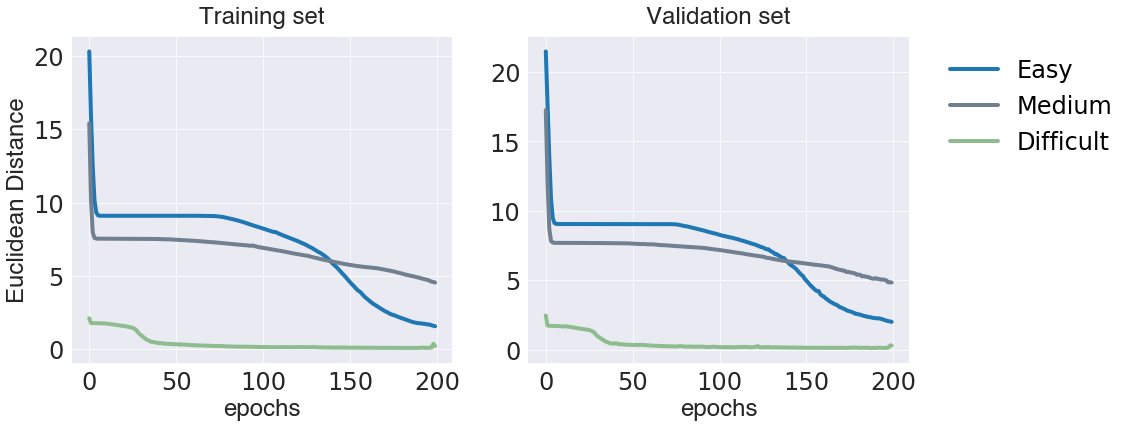

In [15]:
font = 24
hfont = {"fontname": "Helvetica"}

# plt.rcParams["figure.figsize"] = 25, 5.5
plt.rcParams.update({"font.size": font})
plt.rcParams["axes.titlepad"] = 13
plt.rcParams["xtick.major.pad"] = "8"  # axis distance
plt.rcParams["ytick.major.pad"] = "8"

plt.figure(figsize=(15, 6))

with plt.style.context("seaborn-darkgrid"):
    
    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.title("Training set", fontsize=font)
    plt.ylabel("Accuracy", fontsize=font, **hfont)
    plt.xlabel("Epochs", fontsize=font, **hfont)
    
    # easy
    plt.subplot(1, 2, 1)
    (y1,) = plt.plot(
        train_acc[0],
        linestyle="solid",
        c="tab:blue",
        label="Easy",
        linewidth=4.0,
    )
    (y2,) = plt.plot(
        train_acc[1],
        c="slategray",
        linestyle="solid",
        label="Medium",
        linewidth=4.0,
    )
    (y3,) = plt.plot(
        train_acc[2],
        c="darkseagreen",
        linestyle="solid",
        label="Difficult",
        linewidth=4.0,
    )
    
    #plt.ylim(ymax=1.05, ymin=0)
    #plt.yticks(np.arange(0, 1.05, 0.2))
    plt.ylabel("Euclidean Distance", fontsize=font, **hfont)
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Training set", fontsize=font, **hfont)

    plt.subplot(1, 2, 2)
    plt.plot(
        test_acc[0],
        linestyle="solid",
        c="tab:blue",
        label="Easy",
        linewidth=4.0,
    )
    plt.plot(
        test_acc[1],
        c="slategray",
        linestyle="solid",
        label="Medium",
        linewidth=4.0,
    )
    plt.plot(
        test_acc[2],
        c="darkseagreen",
        linestyle="solid",
        label="Difficult",
        linewidth=4.0,
    )

    #plt.ylim(ymax=1.05, ymin=0)
    #plt.yticks(np.arange(0, 1.05, 0.2))
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Validation set", fontsize=font, **hfont)

plt.legend(
    handles=[y1, y2, y3],
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=False,
)
plt.savefig("ConvLSTM_coord_results.pdf", bbox_inches="tight")

### Train model

In [ ]:
criterion = nn.MSELoss()
params = list(net_cnn.parameters()) + list(net_lstm.parameters())
optimizer = optim.Adam(params, lr=0.01)
episodes = 500

(
    train_loss,
    test_loss,
    train_dis,
    test_dis,
    train_dis_item,
    test_dis_item,
) = train.train_ConvLSTM(
    dataset_loader_train_data,
    dataset_loader_test_data,
    net_cnn,
    net_lstm,
    criterion,
    optimizer,
    episodes,
    length_trajectory,
)

### Plot distance and loss over episodes

In [ ]:
plot.plot_euclidean_distance(train_dis, test_dis)
plot.plot_losses(train_loss[10:], test_loss[10:])

### Histogram of the distribution shift (for test and training distances)

In [ ]:
print("Training set \n")
plot.histo_distribution_shift(train_dis_item)
print("Validation set \n")
plot.histo_distribution_shift(test_dis_item)

### Histograms showing the training and validation distance distribution (for test and training distances)

In [ ]:
plot.histo_train_val(test_dis_item, train_dis_item)

### Save and load models